In [13]:
import pandas as pd
import os
import pydicom
import glob
from PIL import Image
import gdcm
import PIL
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#path defs
train_path = '../data/dicom-images-train/'
test_path = '../data/dicom-images-test/'
train_dicom_names = '../data/train-dicom-names.csv'
test_dicom_names = '../data/test-dicom-names.csv'
annot_csv = '../data/train-rle.csv'
sample_data = '../data/sample images/'

### Overview of Data

Issue one user had, look for these issues:
> I was able to download all train data (10712 images) - all I had to use sleep(0.025) before two api calls for each study_uid in download_images.py script. The remaining issue is that there is 37 images in train set which don't have annotations. Two options there - drop them from training, or assume its rle-encoding is "-1""

All dicom images are placed within two folders. E.g.
- ../data/dicom-images-test/
- 1.2.276.0.7230010.3.1.2.8323329.6769.1517875200.68560/ <-- folder 1 of many
- 1.2.276.0.7230010.3.1.3.8323329.6769.1517875200.68559/ <-- folder 2 of one
- 1.2.276.0.7230010.3.1.4.8323329.6769.1517875200.68561.dcm <-- single dicom image

pipe recursive file count to wc: ```find . -type f | wc -l``` Get's us the number of images

Now we need the name of all the dicom images ```find ../data/dicom-images-train/ -type f -printf "%f\n" | paste -sd ',' >> ../data/train-dicom-names``` We will use this to cross ref the annotations csv and also check for duplicate data.


Train Imgs: 10712  -  Annotations: 11582 (8296 = -1, 3286 = disorder annotated) roughly 3:1

Test Imgs: 1377  -  Annotations: No .dcm images are present in the annotation file.

Duplicate Dicom Imgs: No

##### ISSUE: 37 Dicom images are not accounted for in the annotation list. 

##### ISSUE: 1.2.276.0.7230010.3.1.4.8323329.6421.1517875198.98821.dcm in TEST Set
```(7b5b, 200a) Private tag data                    UN: b'ror": {\n    "code": 429,\n    "message": "Quota exceeded for quota metric \'healthcare.googleapis.com/dicom_web_ops\' and limit \'DicomWebOpsPerMinutePerProject\' of service \'healthcare.googleapis.com\' for consumer \'project_number:38125765871\'.",\n    "status": "RESOURCE_EXHAUSTED",\n    "details": [\n      {\n        "@type": "type.googleapis.com/google.rpc.Help",\n        "links": [\n          {\n            "description": "Google developer console API key",\n            "url": "https://console.developers.google.com/project/38125765871/apiui/credential"\n          }\n        ]\n      }\n    ]\n  }\n}\n]'```
path: '../data/dicom-images-test/1.2.276.0.7230010.3.1.2.8323329.6421.1517875198.98820/1.2.276.0.7230010.3.1.3.8323329.6421.1517875198.98819/1.2.276.0.7230010.3.1.4.8323329.6421.1517875198.98821.dcm'
##### ISSUE: 1588 training images are fake news. google never gave the data, nor did the download script return any issue...
yup.. google screwed me over. thanks google..... 1588 instances off google healthcare API saying code: 429: your internet is too fast for our API..



In [3]:
def dicom_count_checker(path, assumed_count):
    '''Assure our dicom counts are correct, no duplicates, and we downloaded the correct amount of data'''
    counted_imgs = 0
    data_set = set()
    with open(path, 'r') as infile:
        for line in infile:
            line = line.strip('\n') #chomp chomp
            counted_imgs += 1
            data_set.add(line)
    assert counted_imgs == assumed_count & len(data_set) == assumed_count
    print(path + ': count assumption valid, no duplicates!')
    return data_set

train_names = dicom_count_checker(train_dicom_names, 10712)
test_names = dicom_count_checker(test_dicom_names, 1377)



../data/train-dicom-names.csv: count assumption valid, no duplicates!
../data/test-dicom-names.csv: count assumption valid, no duplicates!


In [4]:
# ensure no data leakage between train/test. These should be same len 
# between set union and non-concat len addition
assert (len(train_names) + len(test_names)) == len(train_names.union(test_names))
print('no data leakage')

no data leakage


In [5]:
# strip out dicom file names from annotated list
# count the number of annotated files with no disoder present
count = 0
count_no_annot = 0
unique_annotations = set()

with open(annot_csv, 'r') as infile:
    next(infile)
    for line in infile:
        count += 1
        cols = line.split(',')
        cols[1] = cols[1].strip('\n').lstrip() #chomp
        if cols[1] == '-1':
            count_no_annot += 1
        unique_annotations.add(cols[0]+'.dcm')

print('total annotations: ', count)
print('total rows w/o annotations: ',count_no_annot)
print('total unique annotations: ',len(unique_annotations))

total annotations:  11582
total rows w/o annotations:  8296
total unique annotations:  10675


In [6]:
# take the disjoint of the annotated file names with the test file names. Should return an empty set.
assert unique_annotations.isdisjoint(test_names)
print('no annotated test files... yay!')

no annotated test files... yay!


In [7]:
# Here is the issue... not all training images are annotated...
print(len(train_names))
print(len(unique_annotations))

10712
10675


In [8]:
# Here are the bad actors... There are no mentions of these files in the annotations. 
# Do we treat these as a -1? or are these valid cases of the disorder... or drop them!
sym_diff = train_names.symmetric_difference(unique_annotations)
print(len(sym_diff))
sym_diff

37


{'1.2.276.0.7230010.3.1.4.8323329.10231.1517875222.737143.dcm',
 '1.2.276.0.7230010.3.1.4.8323329.10362.1517875223.377845.dcm',
 '1.2.276.0.7230010.3.1.4.8323329.10407.1517875223.567351.dcm',
 '1.2.276.0.7230010.3.1.4.8323329.10599.1517875224.488727.dcm',
 '1.2.276.0.7230010.3.1.4.8323329.1068.1517875166.144255.dcm',
 '1.2.276.0.7230010.3.1.4.8323329.11104.1517875231.169401.dcm',
 '1.2.276.0.7230010.3.1.4.8323329.11215.1517875231.757436.dcm',
 '1.2.276.0.7230010.3.1.4.8323329.11557.1517875233.601090.dcm',
 '1.2.276.0.7230010.3.1.4.8323329.11566.1517875233.640521.dcm',
 '1.2.276.0.7230010.3.1.4.8323329.11577.1517875233.694347.dcm',
 '1.2.276.0.7230010.3.1.4.8323329.11584.1517875233.731531.dcm',
 '1.2.276.0.7230010.3.1.4.8323329.12062.1517875237.179186.dcm',
 '1.2.276.0.7230010.3.1.4.8323329.13378.1517875244.961609.dcm',
 '1.2.276.0.7230010.3.1.4.8323329.13415.1517875245.218707.dcm',
 '1.2.276.0.7230010.3.1.4.8323329.13620.1517875246.884737.dcm',
 '1.2.276.0.7230010.3.1.4.8323329.14557.1

In [9]:
# Let's convert these bad actors to JPEG and see what they look like
outdir = sample_data + '/bad_actors/'
bad_actors = list(sym_diff)
bad_actors_paths = [] #should be 37, assert this

In [10]:
# make a list of filepaths+filenames for all  bad actors
for filename in glob.iglob(train_path + '**/*.dcm', recursive=True):
    potential_bad_actor = filename.split('/')[-1]
    if potential_bad_actor in bad_actors:
        bad_actors_paths.append(filename)
assert len(bad_actors_paths) == 37

In [155]:
def dicom_to_jpeg(filepath, outdir=outdir, print_dicom=False):
    ds = pydicom.read_file(filepath, force=True) # read dicom image
    try:
        img = ds.pixel_array # get image array
    except:
        ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        img = ds.pixel_array # get image array
    if print_dicom == True:
        plt.imshow(img, cmap=plt.cm.bone)
        plt.show()
        return
    img_mem = Image.fromarray(img) # Creates an image memory from an object exporting the array interface
    img_mem.save(outdir + f.replace('.dcm','.jpeg'))
    return

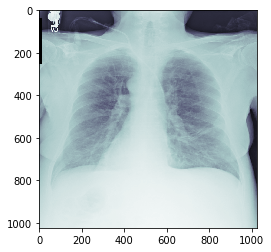

In [157]:
# spot checking these images seem to be at least the right body part.
dicom_to_jpeg(bad_actors_paths[0], print_dicom=True)

ValueError: The length of the pixel data in the dataset (93402 bytes) doesn't match the expected length (1048576 bytes). The dataset may be corrupted or there may be an issue with the pixel data handler.

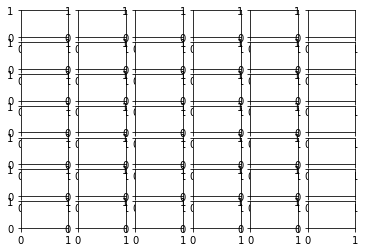

In [30]:
fig, ax = plt.subplots(nrows=7, ncols=6)

count = 0
for row in ax:
    for col in row:
        ds = pydicom.read_file(bad_actors_paths[count], force=True)
        ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian  # or whatever is the correct transfer syntax for the file
        img = ds.pixel_array
        plt.imshow(img, cmap=plt.cm.bone)
        count+= 1
        if count == len(bad_actors_paths):
            break
#         

plt.show()

#### let's check the meta data of dicom size for the training and testing


In [31]:
# make a list of filepaths+filenames for all  data
train_paths = []
test_paths = []
for idx, data_set_path in enumerate([train_path, test_path]):
    for filename in glob.iglob(data_set_path + '**/*.dcm', recursive=True):
        if idx == 0:
            train_paths.append(filename)
        else:
            test_paths.append(filename)
assert len(train_paths) == 10712
assert len(test_paths) == 1377

In [175]:
train_metadata = []
test_metadata = []
for idx, data_set in enumerate([train_paths, test_paths]):
    for dicom in data_set:
        ds = pydicom.dcmread(dicom, force=True)
        ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        data_dict = {} 
        
#         yuck all these try excepts.. see: https://stackoverflow.com/questions/4978738/is-there-a-python-equivalent-of-the-c-sharp-null-coalescing-operator
        
        try:
            data_dict["modality"] = ds.Modality
        except:
            data_dict["modality"] = None
            
        try:
            data_dict["conversion_type"] = ds.ConversionType
        except:
            data_dict["conversion_type"] = None
            
        try:
            data_dict["sex"] = ds.PatientSex
        except:
            data_dict["sex"] = None
            
        try:
            data_dict["age"] = int(ds.PatientAge)
        except:
            data_dict["age"] = None
            
        try:
            data_dict["body_part"] = ds.BodyPartExamined
        except:
            data_dict["body_part"] = None
            
        try:
            data_dict["view_pos"] = ds.ViewPosition
        except:
            data_dict["view_pos"] = None
            
        try:
            data_dict["samples_per_pixel"] = int(ds.SamplesPerPixel)
        except:
            data_dict["samples_per_pixel"] = None
            
        try:
            data_dict["rows"] = int(ds.Rows)
        except:
            data_dict["rows"] = None
            
        try:
            data_dict["cols"] = int(ds.Columns)
        except:
            data_dict["cols"] = None
            
        try:
            data_dict["pixel_spacing_one"] = float(ds.PixelSpacing[0])
        except:
            data_dict["pixel_spacing_one"] = None
            
        try:
            data_dict["pixel_spacing_two"] = float(ds.PixelSpacing[1])
        except:
            data_dict["pixel_spacing_two"] = None
            
        try:
            data_dict["pixels"] = len(ds.PixelData)
        except:
            data_dict["pixels"] = None
            
        try:
            data_dict["dicom_file"] = dicom.split('/')[-1]
        except:
            data_dict["dicom_file"] = None
            
        try:
            data_dict["dicom_path"] = dicom.split('/')[-1]
        except:
            data_dict["dicom_path"] = None
    
        
        if idx == 0:
            train_metadata.append(data_dict)
        else:
            test_metadata.append(data_dict)

assert len(train_metadata) == 10712
assert len(test_metadata) == 1377

# train_metadata[0]

# {'modality': 'CR',
#  'conversion_type': 'WSD',
#  'sex': 'M',
#  'age': 22,
#  'body_part': 'CHEST',
#  'view_pos': 'PA',
#  'samples_per_pixel': 1,
#  'rows': 1024,
#  'cols': 1024,
#  'pixel_spacing_one': 0.168,
#  'pixel_spacing_two': 0.168,
#  'pixels': 126862,
#  'dicom_file': '1.2.276.0.7230010.3.1.4.8323329.3404.1517875177.685322.dcm'}

In [142]:
print(len(train_metadata))
print(len(test_metadata))
train_df = pd.DataFrame.from_dict(train_metadata)
test_df = pd.DataFrame.from_dict(test_metadata)
print(len(train_df.index))
print(len(test_df.index))

10712
1377
10712
1377


In [143]:
# save these pandas df for future use in metadata EDA
train_df.to_pickle("../data/train_metadata_df.pkl")
test_df.to_pickle("../data/test_metadata_df.pkl")

In [144]:
train_df.head(2)

,age,body_part,cols,conversion_type,dicom_file,dicom_path,modality,pixel_spacing_one,pixel_spacing_two,pixels,rows,samples_per_pixel,sex,view_pos
0,22.0,CHEST,1024.0,WSD,1.2.276.0.7230010.3.1.4.8323329.3404.151787517...,../data/dicom-images-train/1.2.276.0.7230010.3...,CR,0.168,0.168,126862.0,1024.0,1.0,M,PA
1,44.0,CHEST,1024.0,WSD,1.2.276.0.7230010.3.1.4.8323329.5176.151787518...,../data/dicom-images-train/1.2.276.0.7230010.3...,CR,0.143,0.143,146768.0,1024.0,1.0,F,PA


In [145]:
train_df.describe()

,age,cols,pixel_spacing_one,pixel_spacing_two,pixels,rows,samples_per_pixel
count,9124.000000,9124.0,9124.000000,9124.000000,9124.000000,9124.0,9124.0
mean,46.951885,1024.0,0.155545,0.155545,134184.071241,1024.0,1.0
std,17.215828,0.0,0.016704,0.016704,22931.057707,0.0,0.0
min,1.000000,1024.0,0.115000,0.115000,40542.000000,1024.0,1.0
25%,34.000000,1024.0,0.143000,0.143000,115816.500000,1024.0,1.0
50%,49.000000,1024.0,0.143000,0.143000,137603.000000,1024.0,1.0
75%,59.000000,1024.0,0.168000,0.168000,152991.000000,1024.0,1.0
max,413.000000,1024.0,0.194336,0.194336,276992.000000,1024.0,1.0


In [146]:
test_df.head(2)

,age,body_part,cols,conversion_type,dicom_file,dicom_path,modality,pixel_spacing_one,pixel_spacing_two,pixels,rows,samples_per_pixel,sex,view_pos
0,65.0,CHEST,1024.0,WSD,1.2.276.0.7230010.3.1.4.8323329.6729.151787519...,../data/dicom-images-test/1.2.276.0.7230010.3....,CR,0.168,0.168,83628.0,1024.0,1.0,M,AP
1,49.0,CHEST,1024.0,WSD,1.2.276.0.7230010.3.1.4.8323329.6769.151787520...,../data/dicom-images-test/1.2.276.0.7230010.3....,CR,0.139,0.139,134492.0,1024.0,1.0,F,PA


In [147]:
test_df.describe()

,age,cols,pixel_spacing_one,pixel_spacing_two,pixels,rows,samples_per_pixel
count,1376.000000,1376.0,1376.000000,1376.000000,1376.000000,1376.0,1376.0
mean,46.316860,1024.0,0.155371,0.155371,132707.414244,1024.0,1.0
std,16.799261,0.0,0.016275,0.016275,22721.864835,0.0,0.0
min,2.000000,1024.0,0.139000,0.139000,62168.000000,1024.0,1.0
25%,34.000000,1024.0,0.143000,0.143000,114172.000000,1024.0,1.0
50%,48.000000,1024.0,0.143000,0.143000,135484.000000,1024.0,1.0
75%,59.000000,1024.0,0.168000,0.168000,151706.500000,1024.0,1.0
max,89.000000,1024.0,0.194314,0.194314,193548.000000,1024.0,1.0


/home/keil/miniconda3/envs/py3x/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/keil/miniconda3/envs/py3x/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


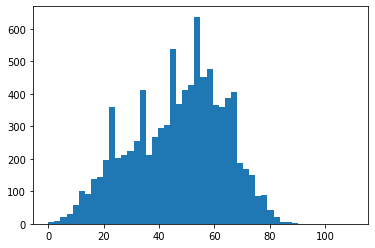

In [148]:
fig1 = plt.hist(train_df.age.to_list(),bins=50,range=(0,110));
plt.show();

/home/keil/miniconda3/envs/py3x/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/keil/miniconda3/envs/py3x/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


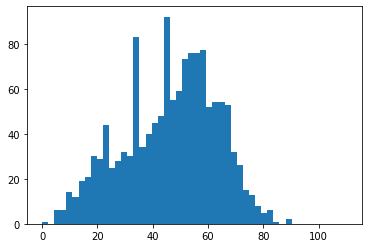

In [149]:
fig1 = plt.hist(test_df.age.to_list(),bins=50,range=(0,110))
plt.show()

In [150]:
print('rows --------------- ')
print(train_df.rows.value_counts(dropna=False))
print(test_df.rows.value_counts(dropna=False))
print('cols --------------- ')
print(train_df.cols.value_counts(dropna=False))
print(test_df.cols.value_counts(dropna=False))

rows --------------- 
1024.0    9124
NaN       1588
Name: rows, dtype: int64
1024.0    1376
NaN          1
Name: rows, dtype: int64
cols --------------- 
1024.0    9124
NaN       1588
Name: cols, dtype: int64
1024.0    1376
NaN          1
Name: cols, dtype: int64


In [151]:
print(train_df.body_part.value_counts(dropna=False))
print(test_df.body_part.value_counts(dropna=False))

CHEST    9124
NaN      1588
Name: body_part, dtype: int64
CHEST    1376
NaN         1
Name: body_part, dtype: int64


In [152]:
print(train_df.modality.value_counts(dropna=False))
print(test_df.modality.value_counts(dropna=False))

CR     9124
NaN    1588
Name: modality, dtype: int64
CR     1376
NaN       1
Name: modality, dtype: int64


In [163]:
#all the same for test, this dicom has much of its meta-data missing...
print(test_df[test_df['modality'].isnull()].dicom_file)
print(test_df[test_df['body_part'].isnull()].dicom_file)
print(test_df[test_df['rows'].isnull()].dicom_file)
print(test_df[test_df['cols'].isnull()].dicom_file)
print(test_df[test_df['pixels'].isnull()].dicom_file)


1028    1.2.276.0.7230010.3.1.4.8323329.6421.151787519...
Name: dicom_file, dtype: object
1028    1.2.276.0.7230010.3.1.4.8323329.6421.151787519...
Name: dicom_file, dtype: object
1028    1.2.276.0.7230010.3.1.4.8323329.6421.151787519...
Name: dicom_file, dtype: object
1028    1.2.276.0.7230010.3.1.4.8323329.6421.151787519...
Name: dicom_file, dtype: object
1028    1.2.276.0.7230010.3.1.4.8323329.6421.151787519...
Name: dicom_file, dtype: object


In [160]:
#lets plot the dicom from test and see if anything looks fishy
# dicom_to_jpeg(test_df[test_df['cols'].isnull()].dicom_path.to_list()[0], print_dicom=True)




ds = pydicom.read_file(test_df[test_df['cols'].isnull()].dicom_path.to_list()[0], force=True) # read dicom image
print(ds)
# try:
#     img = ds.pixel_array # get image array
# except:
#     ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
#     img = ds.pixel_array # get image array
# if print_dicom == True:
#     plt.imshow(img, cmap=plt.cm.bone)
#     plt.show()
#     return
# img_mem = Image.fromarray(img) # Creates an image memory from an object exporting the array interface
# img_mem.save(outdir + f.replace('.dcm','.jpeg'))
# return

(7b5b, 200a) Private tag data                    UN: b'ror": {\n    "code": 429,\n    "message": "Quota exceeded for quota metric \'healthcare.googleapis.com/dicom_web_ops\' and limit \'DicomWebOpsPerMinutePerProject\' of service \'healthcare.googleapis.com\' for consumer \'project_number:38125765871\'.",\n    "status": "RESOURCE_EXHAUSTED",\n    "details": [\n      {\n        "@type": "type.googleapis.com/google.rpc.Help",\n        "links": [\n          {\n            "description": "Google developer console API key",\n            "url": "https://console.developers.google.com/project/38125765871/apiui/credential"\n          }\n        ]\n      }\n    ]\n  }\n}\n]'


In [132]:
# appears that if row is NaN then corresponding col is NaN
cols = train_df[train_df['cols'].isnull()].dicom_file.to_list()
rows = train_df[train_df['rows'].isnull()].dicom_file.to_list()
print(len(set(cols + rows)))
print(len(rows))
print(len(cols))

1588
1588
1588


In [165]:
# potential issue... 1588 pixel data is null
print(len(train_df[train_df['pixels'].isnull()].dicom_file))

1588


In [171]:
# img = train_df[train_df['pixels'].isnull()].dicom_path.to_list()[3]
huh = set()
for img in train_df[train_df['pixels'].isnull()].dicom_path.to_list():
    ds = pydicom.read_file(img, force=True) # read dicom image
    huh.add(len(ds))
huh
# yup.. google screwed me over. thanks google..... 1588 instances off google healthcare API saying 
# code: 429: your internet is too fast for our API...

{1}

In [ ]:
# sample dump from, ds = pydicom.dcmread(dicom, force=True):
    
# (0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
# (0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
# (0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.3404.1517875177.685322
# (0008, 0020) Study Date                          DA: '19010101'
# (0008, 0030) Study Time                          TM: '000000.00'
# (0008, 0050) Accession Number                    SH: ''
# (0008, 0060) Modality                            CS: 'CR'
# (0008, 0064) Conversion Type                     CS: 'WSD'
# (0008, 0090) Referring Physician's Name          PN: ''
# (0008, 103e) Series Description                  LO: 'view: PA'
# (0010, 0010) Patient's Name                      PN: '5418554c-a9bb-4f90-b474-d17096054f0e'
# (0010, 0020) Patient ID                          LO: '5418554c-a9bb-4f90-b474-d17096054f0e'
# (0010, 0030) Patient's Birth Date                DA: ''
# (0010, 0040) Patient's Sex                       CS: 'M'
# (0010, 1010) Patient's Age                       AS: '22'
# (0018, 0015) Body Part Examined                  CS: 'CHEST'
# (0018, 5101) View Position                       CS: 'PA'
# (0020, 000d) Study Instance UID                  UI: 1.2.276.0.7230010.3.1.2.8323329.3404.1517875177.685321
# (0020, 000e) Series Instance UID                 UI: 1.2.276.0.7230010.3.1.3.8323329.3404.1517875177.685320
# (0020, 0010) Study ID                            SH: ''
# (0020, 0011) Series Number                       IS: "1"
# (0020, 0013) Instance Number                     IS: "1"
# (0020, 0020) Patient Orientation                 CS: ''
# (0028, 0002) Samples per Pixel                   US: 1
# (0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
# (0028, 0010) Rows                                US: 1024
# (0028, 0011) Columns                             US: 1024
# (0028, 0030) Pixel Spacing                       DS: ['0.168', '0.168']
# (0028, 0100) Bits Allocated                      US: 8
# (0028, 0101) Bits Stored                         US: 8
# (0028, 0102) High Bit                            US: 7
# (0028, 0103) Pixel Representation                US: 0
# (0028, 2110) Lossy Image Compression             CS: '01'
# (0028, 2114) Lossy Image Compression Method      CS: 'ISO_10918_1'
# (7fe0, 0010) Pixel Data                          OB: Array of 126862 bytes